In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

import utils.sde_lib
import utils.models
import utils.losses as losses
from utils.datasets import get_dataset
import utils.samplers
from utils.misc import dotdict, batch_matrix_product

In [2]:
opts =  dotdict({
    'dataset': 'gmm',
    'lr' : 3e-4,
    'num_iters' : 1000,
    'batch_size' : 512, 
    
})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = get_dataset(opts)
dim = dataset.dim
model_backward = utils.models.MLP(dim=dim,augmented_sde=False).to(device=device)
model_forward = utils.models.MatrixTimeEmbedding(4,2).to(device=device)
itr=500
model_path = f'./exp/momentum/itr_{itr}'

model_backward = torch.load(os.path.join(model_path,f'backward_ema_{itr}.pt'))
model_forward = torch.load(os.path.join(model_path,f'forward_ema_{itr}.pt'))
sde = utils.sde_lib.LinearMomentumSchrodingerBridge()
sde.backward_score = model_backward
sde.forward_score = model_forward

In [3]:
t = torch.linspace(0,1,3, device=device).unsqueeze(0)
model_forward(t)

tensor([[[-0.7269,  0.0000,  5.8958,  0.0000],
         [-0.0000, -0.2376,  0.0000,  6.9044]],

        [[-0.7714,  0.0000,  5.8018,  0.0000],
         [-0.0000, -0.2002,  0.0000,  6.8070]],

        [[-0.8315,  0.0000,  5.7265,  0.0000],
         [-0.0000, -0.1717,  0.0000,  6.7271]]], device='cuda:0')

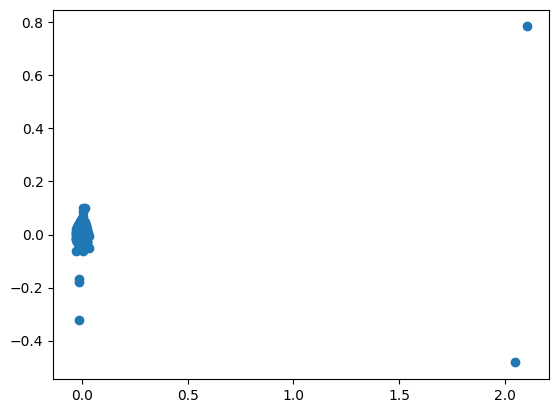

In [5]:
data = dataset.sample(1000).to(device=device)
aug_data = torch.cat((torch.zeros_like(data), data),dim=-1)

noise, trajectory = sde.sample((1000,4),device, True, in_cond=aug_data)

for i in range(trajectory.shape[1]):
    plt.close()
    plt.scatter(trajectory[:,i,0].cpu(),trajectory[:,i,1].cpu())
    plt.savefig(f'trajectory/{i}.png')